In [ ]:
#TODO: implementare XGB
# aggiungere commenti

# ML algorithm for pattern classification
This notebook contains the definitions and training pipeline of the machine learning algorithms applied in the paper.
For each algorithm, a model will be created with the same hyperparameters as the ones declared in the paper (defaults hyperparameters of <code>sklearn</code>).

Said model will be trained and tested on the split already provided from the beginning of the SeqScout procedure. In this way, we can have a score that is as much as comparable as possible with the values reported by the paper.


Then, an hyperparameter search will be conducted on the models via cross validation on the training split. The best performing model will be again trained on the full train set and tested on test set, in order to compare it to the default model.
Each model will be compared on accuracy, precision and recall. Moreover, the confusion matrix for each best performing model will be produced.

## Major differences
Aside from the machine learning library employed, the presented algorithms differ from the original paper in a couple of aspects:
- They use the OneVsRest classifier for each model, while we use directly the multiclass classifier (except for the LinearSVC). This allows to save time on the model training and consequently on the hyperparameter search.
- The results will be computed on a single test split equal to a fifth of the original dataset. This split follows the same split employed for k-fold evaluation in the original paper. This choice was made considering the high overhead required when computing the patterns.
- As SVM model, pyspark has only the LinearSVC implemented, thus it will be used in place of SVC. In this case, the default parameter considered for the baseline model will be the ones provided by pyspark.

In [1]:
!pip freeze

anyio==3.6.2
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
asttokens==2.2.1
attrs==21.2.0
Automat==20.2.0
Babel==2.8.0
backcall==0.2.0
bcrypt==3.2.0
beautifulsoup4==4.11.1
bleach==6.0.0
blinker==1.4
certifi==2020.6.20
cffi==1.15.1
chardet==4.0.0
click==8.0.3
cloud-init==22.3.4
colorama==0.4.4
comm==0.1.2
command-not-found==0.3
configobj==5.0.6
constantly==15.1.0
contourpy==1.0.7
cryptography==3.4.8
cycler==0.11.0
dbus-python==1.2.18
debugpy==1.6.6
decorator==5.1.1
defusedxml==0.7.1
distro==1.7.0
distro-info===1.1build1
docopt==0.6.2
entrypoints==0.4
executing==1.2.0
fastjsonschema==2.16.2
fonttools==4.38.0
hdfs==2.7.0
httplib2==0.20.2
hyperlink==21.0.0
idna==3.3
importlib-metadata==4.6.4
incremental==21.3.0
ipykernel==6.20.2
ipython==8.8.0
ipython-genutils==0.2.0
ipywidgets==8.0.4
jedi==0.18.2
jeepney==0.7.1
Jinja2==3.0.3
joblib==1.3.2
jsonpatch==1.32
jsonpointer==2.0
jsonschema==3.2.0
jupyter==1.0.0
jupyter-console==6.4.4
jupyter-events==0.6.3
jupyter_client==7.4.9
jupyter_core==5.

In [3]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 7.0 MB/s eta 0:00:0000:0100:01


In [1]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LinearSVC, OneVsRest, NaiveBayes
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from utils import load_df
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, IntegerType
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

## Preliminaries and dataset loading

In [2]:
spark = SparkSession.builder.appName("RocketLeagueL").getOrCreate()
#spark = SparkSession.builder.master("local[1]").appName("RocketLeagueL").getOrCreate()

path = "./"
#path = 'hdfs://hdmaster:9000/user/ubuntu/dataset/'
train = load_df(path, "encoded_df", spark)
test = load_df(path, "encoded_test", spark)
seed = 42

#accuracy = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')
#precision = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='weightedPrecision')
#recall = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='weightedRecall')

23/09/17 00:11:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
ordered_labels = ['Noise', 
                      'Ceiling Shot', 
                      'Power Shot', 
                      'Waving Dash',
                      'Air Dribbling',
                      'Front Flick',
                      'Musty Flick']
def print_metrics(prediction_df, ordered_labels=ordered_labels):
    """
    Function printing and returning some metrics for evaluation, as well as the confusion matrix given a pyspark dataframe
    with ground truth labels and predictions. The confusion matrix is printed with values normalized on the true
    positives and false negatives (recall)
    params:
        prediction_df: pyspark dataframe containing at least a prediction column
                       called "prediction" and a class column called "class"
        ordered_labels: list of labels whose position order corresponds to the position order of the corresponding class values
    returns:
        a MulticlassMetrics object containing the metrics about the prediction_df
    """
    rdd_pred = prediction_df.select("prediction", "class").withColumn("class",F.col('class').cast(FloatType())).orderBy('class').rdd.map(tuple)
    metrics = MulticlassMetrics(rdd_pred)
    print("Accuracy: ")
    print(metrics.accuracy)
    print("Weighted precision: ")
    print(metrics.weightedPrecision)
    print("Weighted recall: ")
    print(metrics.weightedRecall)
    cm = metrics.confusionMatrix().toArray()
    cm = cm / (cm.sum(axis=1))
    
    sns.heatmap(cm, annot=True, xticklabels=ordered_labels, yticklabels=ordered_labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    return metrics
    

<BarContainer object of 7 artists>

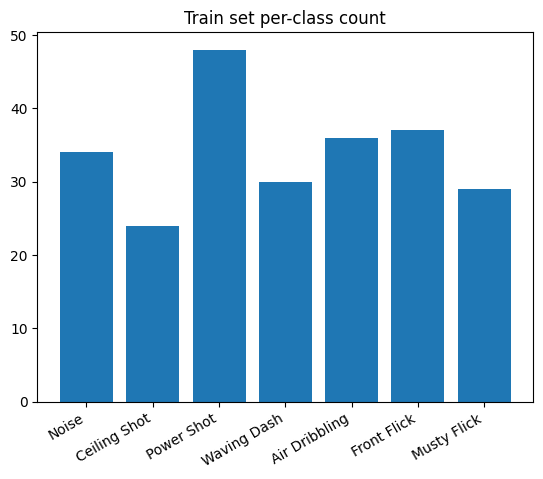

In [4]:
# getting per class counts
hist_data_train = train.groupBy('class').count().sort('class').collect()
# setting label alignment and rotation
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plotting the values
plt.title("Train set per-class count")
plt.bar(np.arange(len(ordered_labels)),[i['count'] for i in hist_data_train], tick_label=ordered_labels)

<BarContainer object of 7 artists>

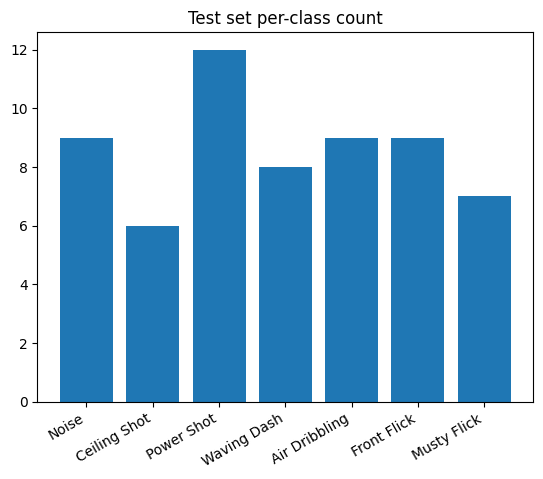

In [5]:
hist_data_test = test.groupBy('class').count().sort('class').collect()
# setting label alignment and rotation
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plotting the values
plt.title("Test set per-class count")
plt.bar(np.arange(len(ordered_labels)),[i['count'] for i in hist_data_test], tick_label=ordered_labels)

## Decision Tree

In [63]:
dtc = DecisionTreeClassifier(maxDepth=30, seed=seed, featuresCol='features', labelCol='class')
# apparently 30 is the currently supported maximum depth for pyspark

dtcf = dtc.fit(train)
dtcf.save(path+"models/decision_tree/base")
dtc_predictions = dtcf.transform(test)

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       0.0|    5|
|       5.0|    5|
+----------+-----+
only showing top 5 rows

Accuracy: 
0.7333333333333333
Weighted precision: 
0.8226527149321267
Weighted recall: 
0.7333333333333333


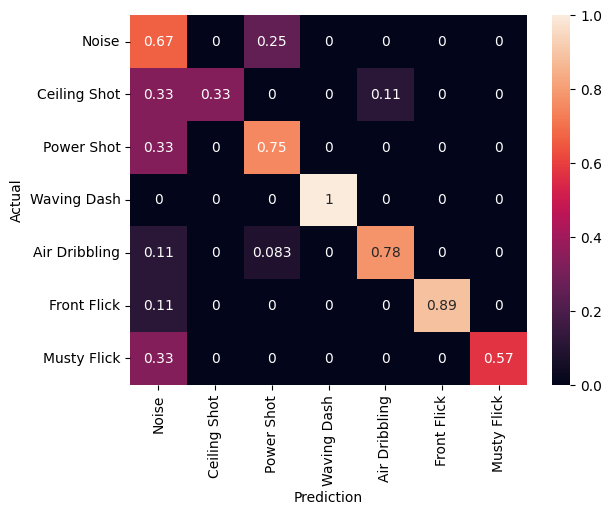

In [64]:
dtc_predictions.select("prediction", "class").show(5)
dtc_metrics = print_metrics(dtc_predictions)

In [65]:
dtc_cv = DecisionTreeClassifier(featuresCol='features', labelCol='class',seed=seed)

dtc_param_grid = ParamGridBuilder()\
                .addGrid(dtc_cv.impurity, ['gini', 'entropy'])\
                .addGrid(dtc_cv.maxDepth, [i+1 for i in range(3,15)])\
                .addGrid(dtc_cv.minInstancesPerNode, [i+1 for i in range(5)])\
                .addGrid(dtc_cv.minInfoGain, [0.1*i for i in range(11)]).build()

evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

dtc_cross_val = CrossValidator(estimator=dtc_cv,
                              estimatorParamMaps=dtc_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [7]:
from pyspark.ml.tuning import CrossValidatorModel
dtc_cv_model = dtc_cross_val.fit(train)
#dtc_cv_model = CrossValidatorModel.load(path+"models/decision_tree/hyperParameterTuned")

In [9]:
# best parameters
print({k.name : v for (k,v) in dtc_cv_model.getEstimatorParamMaps()[np.argmax(dtc_cv_model.avgMetrics)].items()})
dtc_cv_model.save(path+"models/decision_tree/hyperParameterTuned")

{'minInfoGain': 0.2, 'minInstancesPerNode': 2, 'impurity': 'entropy', 'maxDepth': 7}


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
+----------+-----+
only showing top 5 rows

Accuracy: 
0.8
Weighted precision: 
0.8456593406593406
Weighted recall: 
0.7999999999999999


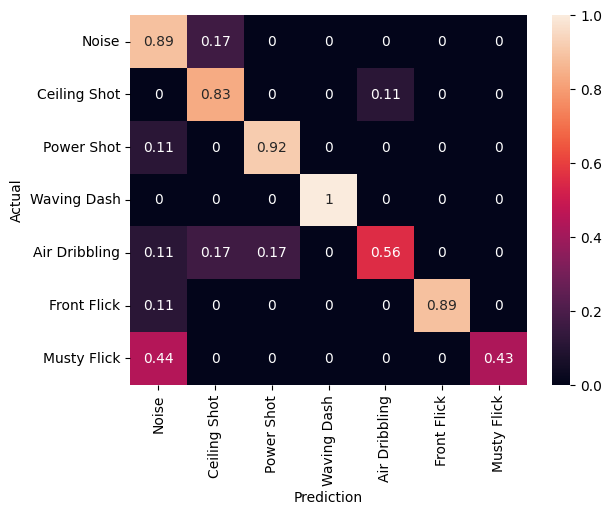

In [68]:
dtc_best_pred = dtc_cv_model.transform(test)
dtc_best_pred.select("prediction", 'class').show(5)
dtc_best_metrics = print_metrics(dtc_best_pred)

## Random Forest

In [69]:
rfc = RandomForestClassifier(featuresCol='features',
                             labelCol='class',
                             featureSubsetStrategy='sqrt',
                             maxDepth=30,
                             numTrees=100,
                             seed=seed)

rfcf = rfc.fit(train)
rfcf.save(path+"models/random_forest/base")
rfc_predictions = rfcf.transform(test)

#print(rfc.explainParams())

23/09/16 16:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1213.0 KiB
23/09/16 16:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1469.4 KiB
23/09/16 16:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1652.3 KiB
23/09/16 16:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1509.6 KiB
23/09/16 16:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1131.0 KiB


23/09/16 16:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1324.7 KiB
+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
+-----+----------+
only showing top 5 rows

23/09/16 16:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1326.7 KiB
23/09/16 16:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1328.4 KiB
23/09/16 16:25:31 WARN DAGScheduler: Broadcasting large task binary with size 1336.6 KiB
Accuracy: 
23/09/16 16:25:31 WARN DAGScheduler: Broadcasting large task binary with size 1347.0 KiB
0.85
Weighted precision: 
0.8741558441558441
Weighted recall: 
0.85


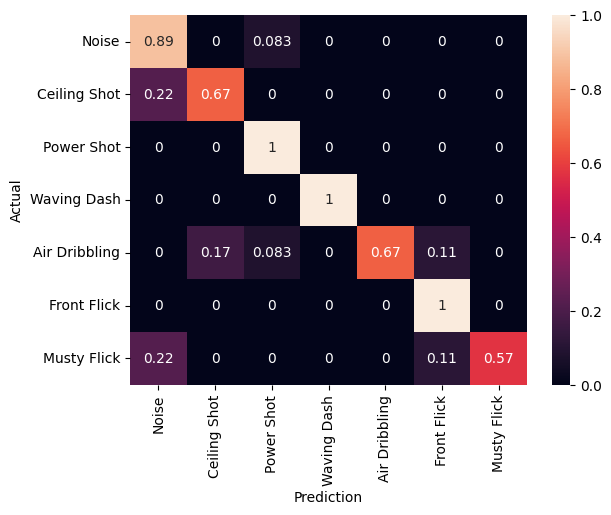

In [71]:
rfc_predictions.select('class', 'prediction').show(5)
rfc_metrics = print_metrics(rfc_predictions)

In [12]:
rfc_cv = RandomForestClassifier(featuresCol='features', labelCol='class',seed=seed)
# in hyperparameters optimization we are considering only the automatic feature selection methods
rfc_param_grid = ParamGridBuilder()\
                .addGrid(rfc_cv.impurity, ['gini', 'entropy'])\
                .addGrid(rfc_cv.maxDepth, [i+1 for i in range(3,10)])\
                .addGrid(rfc_cv.minInstancesPerNode, [i+1 for i in range(3)])\
                .addGrid(rfc_cv.minInfoGain, [0.2*i for i in range(1,6)])\
                .addGrid(rfc_cv.featureSubsetStrategy, ['sqrt', 'all', 'log2', 'onethird'])\
                .addGrid(rfc_cv.numTrees, [25*i for i in range(1,9)])\
                .addGrid(rfc_cv.subsamplingRate, [0.2*i for i in range(1, 6)]).build()

evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

rfc_cross_val = CrossValidator(estimator=rfc_cv,
                              estimatorParamMaps=rfc_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [13]:
rfc_cv_model = rfc_cross_val.fit(train)

23/09/17 08:51:46 WARN BlockManager: Block rdd_1450440_0 already exists on this machine; not re-adding it
23/09/17 09:48:54 WARN DAGScheduler: Broadcasting large task binary with size 1006.8 KiB
23/09/17 09:48:54 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
23/09/17 09:48:55 WARN DAGScheduler: Broadcasting large task binary with size 1028.8 KiB
23/09/17 09:49:09 WARN DAGScheduler: Broadcasting large task binary with size 1001.1 KiB
23/09/17 09:49:10 WARN DAGScheduler: Broadcasting large task binary with size 1010.5 KiB
23/09/17 09:49:11 WARN DAGScheduler: Broadcasting large task binary with size 1071.1 KiB
23/09/17 09:49:12 WARN DAGScheduler: Broadcasting large task binary with size 1124.4 KiB
23/09/17 09:49:13 WARN DAGScheduler: Broadcasting large task binary with size 1133.7 KiB
23/09/17 09:49:23 WARN DAGScheduler: Broadcasting large task binary with size 1001.4 KiB
23/09/17 09:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
23/0

23/09/17 10:07:40 WARN DAGScheduler: Broadcasting large task binary with size 1033.0 KiB
23/09/17 10:07:43 WARN DAGScheduler: Broadcasting large task binary with size 1106.4 KiB
23/09/17 10:07:43 WARN DAGScheduler: Broadcasting large task binary with size 1061.0 KiB
23/09/17 10:07:43 WARN DAGScheduler: Broadcasting large task binary with size 1166.8 KiB
23/09/17 10:07:43 WARN DAGScheduler: Broadcasting large task binary with size 1100.1 KiB
23/09/17 10:10:32 WARN DAGScheduler: Broadcasting large task binary with size 1001.6 KiB
23/09/17 10:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1050.2 KiB
23/09/17 10:10:34 WARN DAGScheduler: Broadcasting large task binary with size 1013.4 KiB
23/09/17 10:10:34 WARN DAGScheduler: Broadcasting large task binary with size 1126.3 KiB
23/09/17 10:10:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.6 KiB
23/09/17 10:10:34 WARN DAGScheduler: Broadcasting large task binary with size 1170.2 KiB
23/09/17 10:10:35 WAR

23/09/17 10:14:47 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB
23/09/17 10:14:48 WARN DAGScheduler: Broadcasting large task binary with size 1085.7 KiB
23/09/17 10:14:48 WARN DAGScheduler: Broadcasting large task binary with size 1083.9 KiB
23/09/17 10:14:50 WARN DAGScheduler: Broadcasting large task binary with size 1081.9 KiB
23/09/17 10:14:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.8 KiB
23/09/17 10:14:51 WARN DAGScheduler: Broadcasting large task binary with size 1095.5 KiB
23/09/17 10:14:51 WARN DAGScheduler: Broadcasting large task binary with size 1132.5 KiB
23/09/17 10:14:52 WARN DAGScheduler: Broadcasting large task binary with size 1280.0 KiB
23/09/17 10:14:52 WARN DAGScheduler: Broadcasting large task binary with size 1171.6 KiB
23/09/17 10:14:52 WARN DAGScheduler: Broadcasting large task binary with size 1226.0 KiB
23/09/17 10:15:05 WARN DAGScheduler: Broadcasting large task binary with size 1006.8 KiB
23/09/17 10:15:06 WAR

23/09/17 10:22:35 WARN DAGScheduler: Broadcasting large task binary with size 1343.6 KiB
23/09/17 10:22:36 WARN DAGScheduler: Broadcasting large task binary with size 1152.7 KiB
23/09/17 10:22:36 WARN DAGScheduler: Broadcasting large task binary with size 1275.0 KiB
23/09/17 10:22:37 WARN DAGScheduler: Broadcasting large task binary with size 1417.6 KiB
23/09/17 10:22:47 WARN DAGScheduler: Broadcasting large task binary with size 1008.4 KiB
23/09/17 10:22:48 WARN DAGScheduler: Broadcasting large task binary with size 1021.8 KiB
23/09/17 10:22:49 WARN DAGScheduler: Broadcasting large task binary with size 1024.2 KiB
23/09/17 10:22:49 WARN DAGScheduler: Broadcasting large task binary with size 1095.3 KiB
23/09/17 10:22:49 WARN DAGScheduler: Broadcasting large task binary with size 1136.8 KiB
23/09/17 10:22:50 WARN DAGScheduler: Broadcasting large task binary with size 1037.2 KiB
23/09/17 10:22:50 WARN DAGScheduler: Broadcasting large task binary with size 1049.6 KiB
23/09/17 10:22:50 WAR

23/09/17 10:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB
23/09/17 10:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1232.6 KiB
23/09/17 10:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1155.7 KiB
23/09/17 10:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1149.1 KiB
23/09/17 10:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1028.8 KiB
23/09/17 10:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1101.6 KiB
23/09/17 10:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1134.3 KiB
23/09/17 10:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1136.4 KiB
23/09/17 10:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1205.5 KiB
23/09/17 10:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1328.4 KiB
23/09/17 10:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1065.5 KiB
23/09/17 10:27:09 WAR

23/09/17 10:34:41 WARN DAGScheduler: Broadcasting large task binary with size 1327.6 KiB
23/09/17 10:34:41 WARN DAGScheduler: Broadcasting large task binary with size 1143.3 KiB
23/09/17 10:34:41 WARN DAGScheduler: Broadcasting large task binary with size 1166.3 KiB
23/09/17 10:34:42 WARN DAGScheduler: Broadcasting large task binary with size 1350.5 KiB
23/09/17 10:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1012.5 KiB
23/09/17 10:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1038.5 KiB
23/09/17 10:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1096.1 KiB
23/09/17 10:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1122.4 KiB
23/09/17 10:34:55 WARN DAGScheduler: Broadcasting large task binary with size 1130.3 KiB
23/09/17 10:34:56 WARN DAGScheduler: Broadcasting large task binary with size 1039.1 KiB
23/09/17 10:34:56 WARN DAGScheduler: Broadcasting large task binary with size 1024.0 KiB
23/09/17 10:34:56 WAR

23/09/17 10:42:07 WARN DAGScheduler: Broadcasting large task binary with size 1120.5 KiB
23/09/17 10:42:26 WARN DAGScheduler: Broadcasting large task binary with size 1009.2 KiB
23/09/17 10:42:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.7 KiB
23/09/17 10:42:29 WARN DAGScheduler: Broadcasting large task binary with size 1024.6 KiB
23/09/17 10:42:30 WARN DAGScheduler: Broadcasting large task binary with size 1026.2 KiB
23/09/17 10:42:30 WARN DAGScheduler: Broadcasting large task binary with size 1133.7 KiB
23/09/17 10:42:45 WARN DAGScheduler: Broadcasting large task binary with size 1053.1 KiB
23/09/17 10:43:00 WARN DAGScheduler: Broadcasting large task binary with size 1013.8 KiB
23/09/17 10:43:00 WARN DAGScheduler: Broadcasting large task binary with size 1033.0 KiB
23/09/17 10:43:00 WARN DAGScheduler: Broadcasting large task binary with size 1128.1 KiB
23/09/17 10:43:00 WARN DAGScheduler: Broadcasting large task binary with size 1032.5 KiB
23/09/17 10:43:02 WAR

23/09/17 10:47:04 WARN DAGScheduler: Broadcasting large task binary with size 1329.3 KiB
23/09/17 10:47:05 WARN DAGScheduler: Broadcasting large task binary with size 1007.7 KiB
23/09/17 10:47:05 WARN DAGScheduler: Broadcasting large task binary with size 1127.5 KiB
23/09/17 10:47:05 WARN DAGScheduler: Broadcasting large task binary with size 1187.6 KiB
23/09/17 10:47:05 WARN DAGScheduler: Broadcasting large task binary with size 1199.3 KiB
23/09/17 10:47:06 WARN DAGScheduler: Broadcasting large task binary with size 1319.0 KiB
23/09/17 10:47:06 WARN DAGScheduler: Broadcasting large task binary with size 1245.8 KiB
23/09/17 10:47:06 WARN DAGScheduler: Broadcasting large task binary with size 1389.6 KiB
23/09/17 10:47:06 WARN DAGScheduler: Broadcasting large task binary with size 1092.8 KiB
23/09/17 10:47:07 WARN DAGScheduler: Broadcasting large task binary with size 1282.6 KiB
23/09/17 10:47:07 WARN DAGScheduler: Broadcasting large task binary with size 1432.6 KiB
23/09/17 10:47:07 WAR

23/09/17 10:55:02 WARN DAGScheduler: Broadcasting large task binary with size 1252.8 KiB
23/09/17 10:55:03 WARN DAGScheduler: Broadcasting large task binary with size 1161.6 KiB
23/09/17 10:56:12 WARN BlockManager: Asked to remove block broadcast_2920977_piece0, which does not exist
23/09/17 10:56:12 WARN BlockManager: Asked to remove block broadcast_2920977, which does not exist
23/09/17 11:16:45 WARN BlockManager: Asked to remove block broadcast_3010934, which does not exist
23/09/17 11:54:56 WARN DAGScheduler: Broadcasting large task binary with size 1019.5 KiB
23/09/17 11:54:56 WARN DAGScheduler: Broadcasting large task binary with size 1038.7 KiB
23/09/17 11:54:57 WARN DAGScheduler: Broadcasting large task binary with size 1038.5 KiB
23/09/17 11:55:13 WARN DAGScheduler: Broadcasting large task binary with size 1036.0 KiB
23/09/17 11:55:14 WARN DAGScheduler: Broadcasting large task binary with size 1059.7 KiB
23/09/17 11:55:15 WARN DAGScheduler: Broadcasting large task binary with 

23/09/17 12:16:52 WARN DAGScheduler: Broadcasting large task binary with size 1162.8 KiB
23/09/17 12:16:52 WARN DAGScheduler: Broadcasting large task binary with size 1104.6 KiB
23/09/17 12:16:53 WARN DAGScheduler: Broadcasting large task binary with size 1241.2 KiB
23/09/17 12:16:53 WARN DAGScheduler: Broadcasting large task binary with size 1056.9 KiB
23/09/17 12:16:53 WARN DAGScheduler: Broadcasting large task binary with size 1244.2 KiB
23/09/17 12:16:53 WARN DAGScheduler: Broadcasting large task binary with size 1294.2 KiB
23/09/17 12:16:53 WARN DAGScheduler: Broadcasting large task binary with size 1051.3 KiB
23/09/17 12:16:53 WARN DAGScheduler: Broadcasting large task binary with size 1234.1 KiB
23/09/17 12:16:54 WARN DAGScheduler: Broadcasting large task binary with size 1308.6 KiB
23/09/17 12:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1018.0 KiB
23/09/17 12:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1083.2 KiB
23/09/17 12:17:11 WAR

23/09/17 12:25:42 WARN DAGScheduler: Broadcasting large task binary with size 1053.6 KiB
23/09/17 12:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1095.8 KiB
23/09/17 12:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1188.4 KiB
23/09/17 12:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1101.4 KiB
23/09/17 12:28:41 WARN DAGScheduler: Broadcasting large task binary with size 1035.7 KiB
23/09/17 12:28:41 WARN DAGScheduler: Broadcasting large task binary with size 1072.3 KiB
23/09/17 12:28:42 WARN DAGScheduler: Broadcasting large task binary with size 1034.7 KiB
23/09/17 12:28:42 WARN DAGScheduler: Broadcasting large task binary with size 1010.3 KiB
23/09/17 12:28:43 WARN DAGScheduler: Broadcasting large task binary with size 1137.9 KiB
23/09/17 12:28:43 WARN DAGScheduler: Broadcasting large task binary with size 1077.8 KiB
23/09/17 12:28:43 WARN DAGScheduler: Broadcasting large task binary with size 1185.5 KiB
23/09/17 12:28:43 WAR

23/09/17 12:33:27 WARN DAGScheduler: Broadcasting large task binary with size 1124.4 KiB
23/09/17 12:33:27 WARN DAGScheduler: Broadcasting large task binary with size 1045.7 KiB
23/09/17 12:33:27 WARN DAGScheduler: Broadcasting large task binary with size 1148.6 KiB
23/09/17 12:33:42 WARN DAGScheduler: Broadcasting large task binary with size 1013.1 KiB
23/09/17 12:33:42 WARN DAGScheduler: Broadcasting large task binary with size 1030.6 KiB
23/09/17 12:33:42 WARN DAGScheduler: Broadcasting large task binary with size 1147.6 KiB
23/09/17 12:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1022.8 KiB
23/09/17 12:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1081.8 KiB
23/09/17 12:33:43 WARN BlockManager: Block broadcast_3365215 could not be removed as it was not found on disk or in memory
23/09/17 12:33:43 ERROR BlockManagerStorageEndpoint: Error in removing broadcast 3365215
org.apache.spark.SparkException: Block broadcast_3365215 does not exist
	at 

23/09/17 12:40:46 WARN DAGScheduler: Broadcasting large task binary with size 1051.3 KiB
23/09/17 12:40:46 WARN DAGScheduler: Broadcasting large task binary with size 1049.6 KiB
23/09/17 12:40:46 WARN DAGScheduler: Broadcasting large task binary with size 1234.1 KiB
23/09/17 12:40:46 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
23/09/17 12:40:46 WARN DAGScheduler: Broadcasting large task binary with size 1371.1 KiB
23/09/17 12:40:46 WARN DAGScheduler: Broadcasting large task binary with size 1399.9 KiB
23/09/17 12:41:00 WARN DAGScheduler: Broadcasting large task binary with size 1009.3 KiB
23/09/17 12:41:02 WARN DAGScheduler: Broadcasting large task binary with size 1021.4 KiB
23/09/17 12:41:03 WARN DAGScheduler: Broadcasting large task binary with size 1091.5 KiB
23/09/17 12:41:04 WARN DAGScheduler: Broadcasting large task binary with size 1150.9 KiB
23/09/17 12:41:05 WARN DAGScheduler: Broadcasting large task binary with size 1036.3 KiB
23/09/17 12:41:05 WAR

23/09/17 12:45:57 WARN DAGScheduler: Broadcasting large task binary with size 1229.4 KiB
23/09/17 12:49:04 WARN DAGScheduler: Broadcasting large task binary with size 1041.9 KiB
23/09/17 12:49:05 WARN DAGScheduler: Broadcasting large task binary with size 1034.9 KiB
23/09/17 12:49:05 WARN DAGScheduler: Broadcasting large task binary with size 1088.9 KiB
23/09/17 12:49:26 WARN DAGScheduler: Broadcasting large task binary with size 1014.0 KiB
23/09/17 12:49:26 WARN DAGScheduler: Broadcasting large task binary with size 1079.8 KiB
23/09/17 12:49:41 WARN DAGScheduler: Broadcasting large task binary with size 1000.4 KiB
23/09/17 12:49:42 WARN DAGScheduler: Broadcasting large task binary with size 1053.9 KiB
23/09/17 12:49:59 WARN DAGScheduler: Broadcasting large task binary with size 1044.6 KiB
23/09/17 12:49:59 WARN DAGScheduler: Broadcasting large task binary with size 1005.8 KiB
23/09/17 12:49:59 WARN DAGScheduler: Broadcasting large task binary with size 1057.6 KiB
23/09/17 12:49:59 WAR

23/09/17 12:57:10 WARN DAGScheduler: Broadcasting large task binary with size 1166.5 KiB
23/09/17 12:57:10 WARN DAGScheduler: Broadcasting large task binary with size 1025.0 KiB
23/09/17 12:57:11 WARN DAGScheduler: Broadcasting large task binary with size 1215.2 KiB
23/09/17 12:57:29 WARN DAGScheduler: Broadcasting large task binary with size 1032.4 KiB
23/09/17 12:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1033.6 KiB
23/09/17 12:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1102.0 KiB
23/09/17 12:57:33 WARN DAGScheduler: Broadcasting large task binary with size 1009.9 KiB
23/09/17 12:57:33 WARN DAGScheduler: Broadcasting large task binary with size 1075.2 KiB
23/09/17 12:57:34 WARN DAGScheduler: Broadcasting large task binary with size 1174.1 KiB
23/09/17 12:57:48 WARN DAGScheduler: Broadcasting large task binary with size 1024.6 KiB
23/09/17 12:57:49 WARN DAGScheduler: Broadcasting large task binary with size 1048.8 KiB
23/09/17 12:57:50 WAR

23/09/17 14:23:08 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB
23/09/17 14:23:35 WARN DAGScheduler: Broadcasting large task binary with size 1039.0 KiB
23/09/17 14:23:35 WARN DAGScheduler: Broadcasting large task binary with size 1028.3 KiB
23/09/17 14:26:26 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB
23/09/17 14:26:26 WARN DAGScheduler: Broadcasting large task binary with size 1077.1 KiB
23/09/17 14:26:27 WARN DAGScheduler: Broadcasting large task binary with size 1063.4 KiB
23/09/17 14:26:27 WARN DAGScheduler: Broadcasting large task binary with size 1114.5 KiB
23/09/17 14:26:27 WARN DAGScheduler: Broadcasting large task binary with size 1058.8 KiB
23/09/17 14:26:27 WARN DAGScheduler: Broadcasting large task binary with size 1107.1 KiB
23/09/17 14:26:28 WARN DAGScheduler: Broadcasting large task binary with size 1105.5 KiB
23/09/17 14:26:28 WARN DAGScheduler: Broadcasting large task binary with size 1104.9 KiB
23/09/17 14:26:29 WAR

23/09/17 14:38:08 WARN DAGScheduler: Broadcasting large task binary with size 1046.3 KiB
23/09/17 14:38:09 WARN DAGScheduler: Broadcasting large task binary with size 1165.6 KiB
23/09/17 14:38:10 WARN DAGScheduler: Broadcasting large task binary with size 1125.0 KiB
23/09/17 14:38:10 WARN DAGScheduler: Broadcasting large task binary with size 1104.9 KiB
23/09/17 14:38:10 WARN DAGScheduler: Broadcasting large task binary with size 1258.0 KiB
23/09/17 14:38:10 WARN DAGScheduler: Broadcasting large task binary with size 1168.2 KiB
23/09/17 14:38:11 WARN DAGScheduler: Broadcasting large task binary with size 1102.8 KiB
23/09/17 14:38:11 WARN DAGScheduler: Broadcasting large task binary with size 1304.5 KiB
23/09/17 14:38:11 WARN DAGScheduler: Broadcasting large task binary with size 1173.6 KiB
23/09/17 14:38:11 WARN DAGScheduler: Broadcasting large task binary with size 1144.8 KiB
23/09/17 14:38:11 WARN DAGScheduler: Broadcasting large task binary with size 1315.4 KiB
23/09/17 14:38:27 WAR

23/09/17 14:50:24 WARN DAGScheduler: Broadcasting large task binary with size 1181.5 KiB
23/09/17 14:50:25 WARN DAGScheduler: Broadcasting large task binary with size 1058.8 KiB
23/09/17 14:50:25 WARN DAGScheduler: Broadcasting large task binary with size 1046.3 KiB
23/09/17 14:50:25 WARN DAGScheduler: Broadcasting large task binary with size 1189.1 KiB
23/09/17 14:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1129.8 KiB
23/09/17 14:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1104.9 KiB
23/09/17 14:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1270.6 KiB
23/09/17 14:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1168.2 KiB
23/09/17 14:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1102.8 KiB
23/09/17 14:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1322.9 KiB
23/09/17 14:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1173.6 KiB
23/09/17 14:50:27 WAR

23/09/17 15:02:27 WARN DAGScheduler: Broadcasting large task binary with size 1127.7 KiB
23/09/17 15:02:28 WARN DAGScheduler: Broadcasting large task binary with size 1063.4 KiB
23/09/17 15:02:28 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
23/09/17 15:02:28 WARN DAGScheduler: Broadcasting large task binary with size 1058.8 KiB
23/09/17 15:02:28 WARN DAGScheduler: Broadcasting large task binary with size 1187.3 KiB
23/09/17 15:02:28 WARN DAGScheduler: Broadcasting large task binary with size 1046.3 KiB
23/09/17 15:02:28 WARN DAGScheduler: Broadcasting large task binary with size 1195.0 KiB
23/09/17 15:02:29 WARN DAGScheduler: Broadcasting large task binary with size 1130.7 KiB
23/09/17 15:02:30 WARN DAGScheduler: Broadcasting large task binary with size 1104.9 KiB
23/09/17 15:02:30 WARN DAGScheduler: Broadcasting large task binary with size 1273.9 KiB
23/09/17 15:02:30 WARN DAGScheduler: Broadcasting large task binary with size 1168.2 KiB
23/09/17 15:02:30 WAR

23/09/17 15:12:08 WARN BlockManager: Asked to remove block broadcast_4105399_piece0, which does not exist
23/09/17 15:12:57 WARN BlockManager: Asked to remove block broadcast_4109816_piece0, which does not exist
23/09/17 16:11:25 WARN BlockManager: Asked to remove block broadcast_4368505_piece0, which does not exist
23/09/17 16:13:26 WARN DAGScheduler: Broadcasting large task binary with size 1002.2 KiB
23/09/17 16:13:26 WARN DAGScheduler: Broadcasting large task binary with size 1009.4 KiB
23/09/17 16:13:43 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
23/09/17 16:13:43 WARN DAGScheduler: Broadcasting large task binary with size 1030.5 KiB
23/09/17 16:13:44 WARN DAGScheduler: Broadcasting large task binary with size 1046.5 KiB
23/09/17 16:14:10 WARN DAGScheduler: Broadcasting large task binary with size 1022.7 KiB
23/09/17 16:14:10 WARN DAGScheduler: Broadcasting large task binary with size 1014.5 KiB
23/09/17 16:14:11 WARN DAGScheduler: Broadcasting large tas

23/09/17 16:35:56 WARN DAGScheduler: Broadcasting large task binary with size 1052.2 KiB
23/09/17 16:35:56 WARN DAGScheduler: Broadcasting large task binary with size 1180.7 KiB
23/09/17 16:35:56 WARN DAGScheduler: Broadcasting large task binary with size 1092.9 KiB
23/09/17 16:35:56 WARN DAGScheduler: Broadcasting large task binary with size 1206.3 KiB
23/09/17 16:35:56 WARN DAGScheduler: Broadcasting large task binary with size 1154.4 KiB
23/09/17 16:35:57 WARN DAGScheduler: Broadcasting large task binary with size 1237.2 KiB
23/09/17 16:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1040.7 KiB
23/09/17 16:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1016.8 KiB
23/09/17 16:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1086.7 KiB
23/09/17 16:36:11 WARN DAGScheduler: Broadcasting large task binary with size 1104.2 KiB
23/09/17 16:36:11 WARN DAGScheduler: Broadcasting large task binary with size 1026.3 KiB
23/09/17 16:36:11 WAR

23/09/17 16:47:42 WARN DAGScheduler: Broadcasting large task binary with size 1044.6 KiB
23/09/17 16:47:43 WARN DAGScheduler: Broadcasting large task binary with size 1181.5 KiB
23/09/17 16:47:44 WARN DAGScheduler: Broadcasting large task binary with size 1252.1 KiB
23/09/17 16:47:44 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
23/09/17 16:47:45 WARN DAGScheduler: Broadcasting large task binary with size 1163.0 KiB
23/09/17 16:47:45 WARN DAGScheduler: Broadcasting large task binary with size 1318.1 KiB
23/09/17 16:47:57 WARN DAGScheduler: Broadcasting large task binary with size 1013.5 KiB
23/09/17 16:47:58 WARN DAGScheduler: Broadcasting large task binary with size 1090.8 KiB
23/09/17 16:47:59 WARN DAGScheduler: Broadcasting large task binary with size 1029.2 KiB
23/09/17 16:47:59 WARN DAGScheduler: Broadcasting large task binary with size 1119.4 KiB
23/09/17 16:47:59 WARN DAGScheduler: Broadcasting large task binary with size 1046.6 KiB
23/09/17 16:47:59 WAR

23/09/17 16:56:21 WARN DAGScheduler: Broadcasting large task binary with size 1050.7 KiB
23/09/17 16:56:21 WARN DAGScheduler: Broadcasting large task binary with size 1057.8 KiB
23/09/17 16:56:21 WARN DAGScheduler: Broadcasting large task binary with size 1192.8 KiB
23/09/17 16:56:22 WARN DAGScheduler: Broadcasting large task binary with size 1129.2 KiB
23/09/17 16:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1049.3 KiB
23/09/17 16:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1034.4 KiB
23/09/17 16:59:14 WARN DAGScheduler: Broadcasting large task binary with size 1051.0 KiB
23/09/17 16:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1122.9 KiB
23/09/17 16:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1011.4 KiB
23/09/17 16:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1176.8 KiB
23/09/17 16:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
23/09/17 16:59:15 WAR

23/09/17 17:04:05 WARN DAGScheduler: Broadcasting large task binary with size 1162.4 KiB
23/09/17 17:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1064.8 KiB
23/09/17 17:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB
23/09/17 17:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1149.6 KiB
23/09/17 17:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1029.6 KiB
23/09/17 17:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
23/09/17 17:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1092.5 KiB
23/09/17 17:04:23 WARN DAGScheduler: Broadcasting large task binary with size 1025.2 KiB
23/09/17 17:04:23 WARN DAGScheduler: Broadcasting large task binary with size 1087.4 KiB
23/09/17 17:04:23 WARN DAGScheduler: Broadcasting large task binary with size 1108.8 KiB
23/09/17 17:04:24 WARN DAGScheduler: Broadcasting large task binary with size 1062.4 KiB
23/09/17 17:04:24 WAR

23/09/17 17:12:32 WARN DAGScheduler: Broadcasting large task binary with size 1161.2 KiB
23/09/17 17:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1347.3 KiB
23/09/17 17:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1366.6 KiB
23/09/17 17:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1228.6 KiB
23/09/17 17:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1409.8 KiB
23/09/17 17:15:38 WARN DAGScheduler: Broadcasting large task binary with size 1041.5 KiB
23/09/17 17:15:38 WARN DAGScheduler: Broadcasting large task binary with size 1001.6 KiB
23/09/17 17:15:38 WARN DAGScheduler: Broadcasting large task binary with size 1069.3 KiB
23/09/17 17:15:39 WARN DAGScheduler: Broadcasting large task binary with size 1003.3 KiB
23/09/17 17:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1008.4 KiB
23/09/17 17:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1100.1 KiB
23/09/17 17:15:40 WAR

In [14]:
# best parameters
print({k.name : v for (k,v) in rfc_cv_model.getEstimatorParamMaps()[np.argmax(rfc_cv_model.avgMetrics)].items()})
rfc_cv_model.save(path+"models/random_forest/hyperParameterTuned")

{'impurity': 'entropy', 'maxDepth': 7, 'minInstancesPerNode': 1, 'minInfoGain': 0.2, 'featureSubsetStrategy': 'onethird', 'numTrees': 25, 'subsamplingRate': 0.8}
23/09/17 17:26:43 WARN TaskSetManager: Stage 3150033 contains a task of very large size (24569 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
+----------+-----+
only showing top 5 rows

Accuracy: 
0.8833333333333333
Weighted precision: 
0.896996336996337
Weighted recall: 
0.8833333333333333


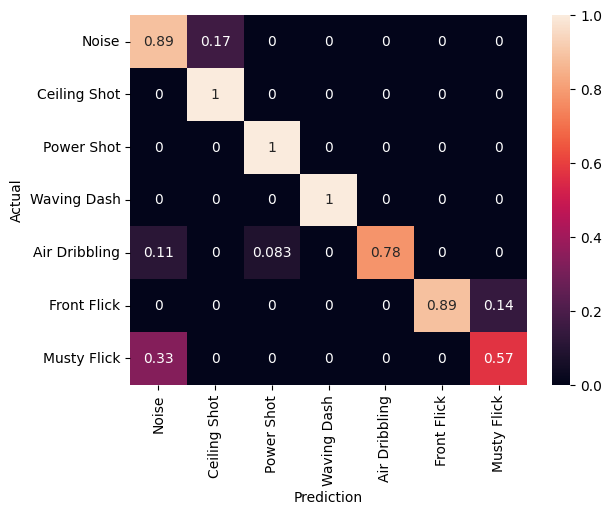

In [15]:
rfc_best_pred = rfc_cv_model.transform(test)
rfc_best_pred.select("prediction", 'class').show(5)
rfc_best_metrics = print_metrics(rfc_best_pred)

## XGBoost

In [18]:
xgb = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         random_state=seed)
xgbf = xgb.fit(train)
xgbf.save(path+'models/xgb/base')
xgb_predictions = xgbf.transform(test)

2023-09-17 18:14:50,810 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'random_state': 42, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[18:14:55] task 0 got new rank 0                                    (0 + 1) / 1]
2023-09-17 18:14:57,483 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Finished xgboost training!


INFO:XGBoost-PySpark:Do the inference on the CPUs


+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
+-----+----------+
only showing top 5 rows



2023-09-17 18:15:11,218 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-09-17 18:15:11,350 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
/usr/local/spark-3.3.1-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 
0.8333333333333334
Weighted precision: 
0.8994117647058825
Weighted recall: 
0.8333333333333333


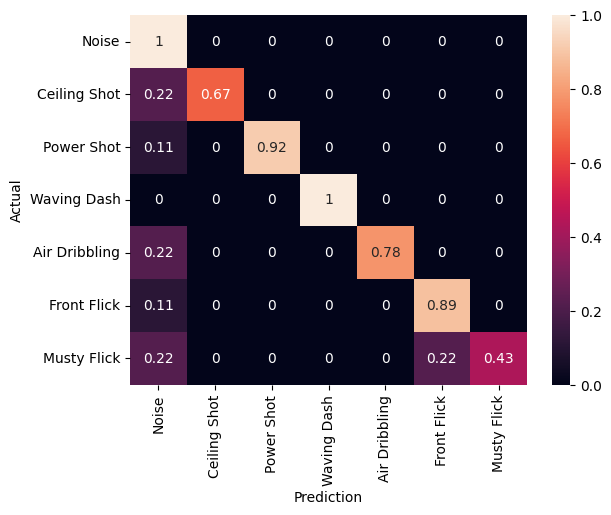

In [19]:
xgb_predictions.select('class', 'prediction').show(5)
xgb_metrics = print_metrics(xgb_predictions)

In [22]:
dir(SparkXGBClassifier)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_convert_to_sklearn_model',
 '_copyValues',
 '_copy_params',
 '_create_pyspark_model',
 '_dummy',
 '_fit',
 '_gen_fit_params_dict',
 '_gen_predict_params_dict',
 '_gen_xgb_params_dict',
 '_get_distributed_train_params',
 '_get_fit_params_default',
 '_get_predict_params_default',
 '_get_xgb_parameters',
 '_get_xgb_params_default',
 '_get_xgb_train_call_args',
 '_is_protocol',
 '_prepare_input',
 '_prepare_input_columns_and_feature_prop',
 '_pyspark_model_cls',
 '_query_plan_contains_valid_rep

## SVM

In [21]:
svm = OneVsRest(classifier=LinearSVC(), featuresCol='features', labelCol='class', parallelism=2)
svmf = svm.fit(train)
svmf.save(path+"models/svm/base")
svm_predictions = svmf.transform(test)

+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       0.0|
|    5|       5.0|
+-----+----------+
only showing top 5 rows



Accuracy: 
0.7666666666666667
Weighted precision: 
0.8145969498910675
Weighted recall: 
0.7666666666666666


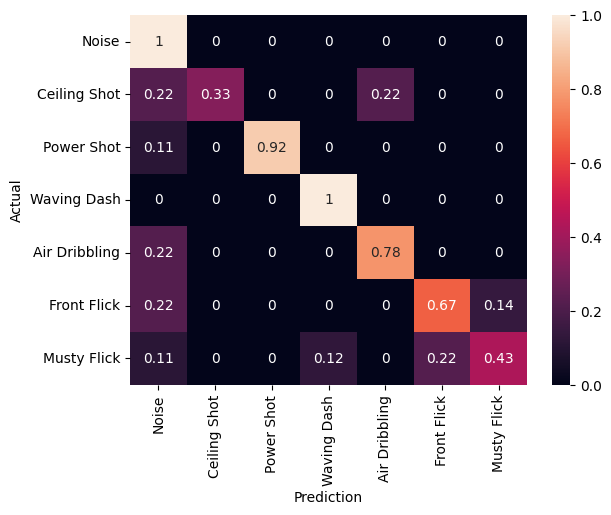

In [22]:
svm_predictions.select('class', 'prediction').show(5)
svm_metrics = print_metrics(svm_predictions)

In [7]:
svm_base = LinearSVC()
svm_cv = OneVsRest(classifier=svm_base,featuresCol='features', labelCol='class')
svm_param_grid = ParamGridBuilder()\
    .addGrid(svm_base.maxIter, [50,100,500 ])\
    .addGrid(svm_base.regParam, [0.001, 0.01, 0.1, 1.0, 10, 100, 1000])\
    .addGrid(svm_base.fitIntercept, [True, False])\
    .addGrid(svm_base.tol, [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]).build()


evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')
svm_cross_val = CrossValidator(estimator=svm_cv,
                              estimatorParamMaps=svm_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [8]:
svm_cv_model = svm_cross_val.fit(train)

23/09/17 00:28:03 WARN BlockManager: Asked to remove block broadcast_187366_piece0, which does not exist
23/09/17 00:30:59 WARN BlockManager: Asked to remove block broadcast_227229_piece0, which does not exist
23/09/17 00:39:05 WARN BlockManager: Asked to remove block broadcast_332444, which does not exist
23/09/17 00:51:18 WARN BlockManager: Asked to remove block broadcast_504038, which does not exist
23/09/17 01:03:39 WARN BlockManager: Asked to remove block broadcast_665939, which does not exist


23/09/17 01:12:15 WARN BlockManager: Asked to remove block broadcast_777638_piece0, which does not exist


23/09/17 01:22:45 WARN BlockManager: Asked to remove block broadcast_916153, which does not exist
23/09/17 01:31:06 WARN BlockManager: Asked to remove block broadcast_1034534_piece0, which does not exist
23/09/17 01:38:11 WARN BlockManager: Asked to remove block broadcast_1132878_piece0, which does not exist
23/09/17 01:41:15 WARN BlockManager: Asked to remove block broadcast_1173986_piece0, which does not exist
23/09/17 01:51:40 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/17 01:51:42 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/17 01:51:54 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/17 01:51:56 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/17 01:52:08 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/17 01:52:11 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/17 02:05:24 ERROR OWLQN: Failure! Resetting histor

23/09/17 02:13:01 WARN BlockManager: Asked to remove block broadcast_1591829, which does not exist
23/09/17 02:23:55 WARN BlockManager: Asked to remove block broadcast_1743750_piece0, which does not exist
23/09/17 02:25:51 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/17 02:25:55 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/17 02:26:04 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/17 02:26:09 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/17 02:26:19 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/17 02:26:24 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/17 02:31:08 WARN BlockManager: Asked to remove block broadcast_1836109_piece0, which does not exist
23/09/17 02:35:26 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
23/09/17 02:35:30 ERROR OWLQN: Failure! Resetting history: breeze.optimiz

In [9]:
print(svm_cv_model.avgMetrics)

[0.8289481787920302, 0.8350547984714111, 0.831431610065614, 0.831431610065614, 0.831431610065614, 0.831431610065614, 0.815806610065614, 0.800307415218593, 0.800307415218593, 0.800307415218593, 0.800307415218593, 0.800307415218593, 0.840716030355469, 0.8252168355084482, 0.8252168355084482, 0.8252168355084482, 0.8252168355084482, 0.8252168355084482, 0.8120752667820319, 0.815806610065614, 0.8121834216598168, 0.8121834216598168, 0.8121834216598168, 0.8121834216598168, 0.8444473736390511, 0.8609530097099045, 0.856323380080275, 0.856323380080275, 0.856323380080275, 0.856323380080275, 0.8268924850385753, 0.8276826165068378, 0.831305804912635, 0.831305804912635, 0.831305804912635, 0.831305804912635, 0.8366222931237531, 0.8366222931237531, 0.8366222931237531, 0.8366222931237531, 0.8366222931237531, 0.8366222931237531, 0.8402454815295503, 0.8402454815295503, 0.8402454815295503, 0.8402454815295503, 0.8402454815295503, 0.8402454815295503, 0.796022529261903, 0.796022529261903, 0.796022529261903, 0.

In [10]:
# best parameters
print({k.name : v for (k,v) in svm_cv_model.getEstimatorParamMaps()[np.argmax(svm_cv_model.avgMetrics)].items()})
svm_cv_model.save(path+"models/svm/hyperParameterTuned")

{'maxIter': 50, 'regParam': 0.1, 'fitIntercept': True, 'tol': 0.01}


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
+----------+-----+
only showing top 5 rows



/usr/local/spark-3.3.1-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 
0.8166666666666667
Weighted precision: 
0.8585416666666668
Weighted recall: 
0.8166666666666667


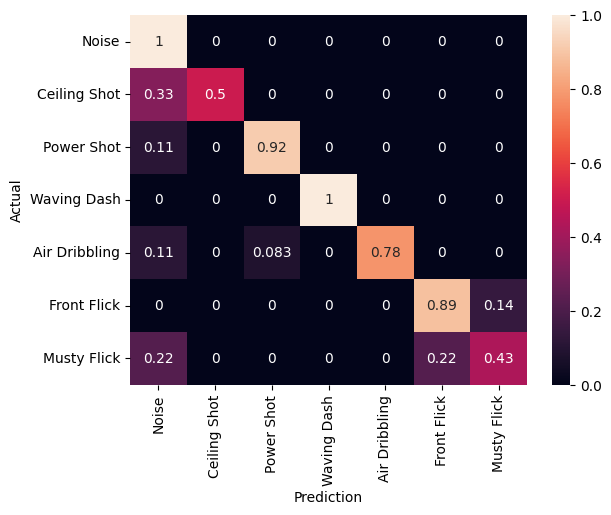

In [11]:
svm_best_pred = svm_cv_model.transform(test)
svm_best_pred.select("prediction", 'class').show(5)
svm_best_metrics = print_metrics(svm_best_pred)

## Naive Bayes

In [12]:
nb = NaiveBayes(featuresCol='features', labelCol='class', smoothing=1e-9,
               modelType='gaussian')
nbf = nb.fit(train)
nbf.save(path+"models/nb/base")
nb_predictions = nbf.transform(test)

+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
+-----+----------+
only showing top 5 rows

Accuracy: 
0.6666666666666666
Weighted precision: 
0.7418849206349207
Weighted recall: 
0.6666666666666666


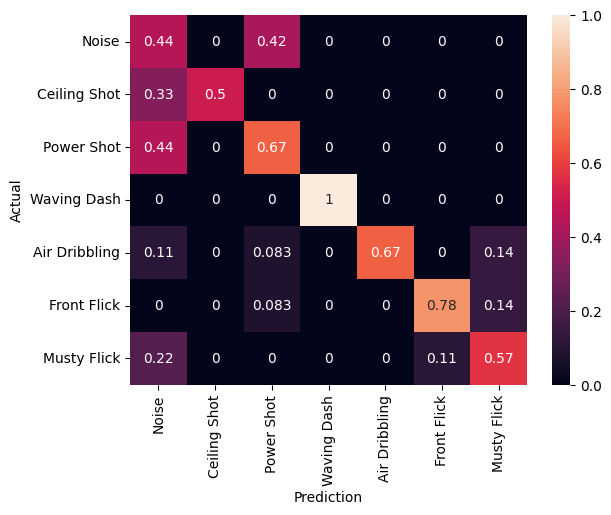

In [13]:
nb_predictions.select('class', 'prediction').show(5)
nb_metrics = print_metrics(nb_predictions)

In [17]:
nb_cv = NaiveBayes(featuresCol='features', labelCol='class')

nb_param_grid = ParamGridBuilder()\
    .addGrid(nb_cv.smoothing, [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9])\
    .addGrid(nb_cv.modelType, ['multinomial','gaussian', 'bernoulli']).build()


evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')
nb_cross_val = CrossValidator(estimator=nb_cv,
                              estimatorParamMaps=nb_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)

In [18]:
nb_cv_model = nb_cross_val.fit(train)

23/09/16 17:33:30 WARN BlockManager: Block rdd_133_0 already exists on this machine; not re-adding it
23/09/16 17:33:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/09/16 17:33:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [19]:
# best parameters
print({k.name : v for (k,v) in nb_cv_model.getEstimatorParamMaps()[np.argmax(nb_cv_model.avgMetrics)].items()})
nb_cv_model.save(path+"models/nb/hyperParameterTuned")

{'smoothing': 0.01, 'modelType': 'bernoulli'}


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
+----------+-----+
only showing top 5 rows

Accuracy: 
0.7833333333333333
Weighted precision: 
0.82
Weighted recall: 
0.7833333333333332


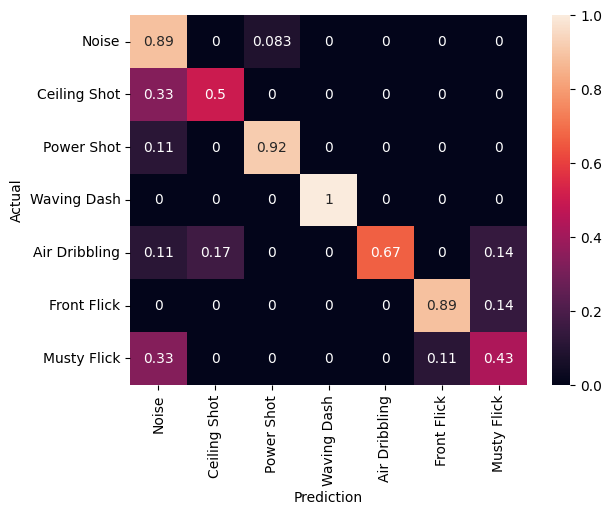

In [20]:
nb_best_pred = nb_cv_model.transform(test)
nb_best_pred.select("prediction", 'class').show(5)
nb_best_metrics = print_metrics(nb_best_pred)

In [38]:
model_names = ['DT', 'RF', 'XGB', 'SVM', 'NB']
final_metrics = [dtc_metrics, rfc_metrics, xgb_metrics, svm_metrics, nb_metrics]
improved_metrics = [dtc_best_metrics, rfc_best_metrics, xgb_best_metrics, svm_best_metrics, nb_best_metrics]

NameError: name 'dtc_metrics' is not defined

Exception ignored in: <function JavaWrapper.__del__ at 0x7fc3d47c60e0>          
Traceback (most recent call last):
  File "/usr/local/spark-3.3.1-bin-hadoop3/python/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'NaiveBayes' object has no attribute '_java_obj'


In [ ]:
plt.title("Test Accuracy")
plt.bar(np.arange(len(model_names)),[i.accuracy for i in final_metrics], tick_label=model_names)


In [ ]:
plt.title("Test Precision")
plt.bar(np.arange(len(model_names)),[i.weightedPrecision for i in final_metrics], tick_label=model_names)


In [ ]:
plt.title("Test Recall")
plt.bar(np.arange(len(model_names)),[i.weightedRecall for i in final_metrics], tick_label=model_names)
